In [11]:
import json
import os
import random
import shutil
import subprocess
import logging
from pathlib import Path
from typing import Tuple, List, Dict, Any
import requests
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

Limpeza do dataset

In [ ]:
# Configuração de logging para acompanhar o processamento
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def clean_annotations_by_filename(
    annotations_path: Path, images_dir: Path, output_path: Path
) -> None:

    # Lista os nomes dos arquivos presentes no diretório de imagens
    existing_files = {f.name for f in images_dir.iterdir() if f.is_file()}
    
    # Carrega o arquivo JSON de anotações
    with annotations_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Filtra as imagens do JSON para manter apenas aquelas que existem no diretório
    filtered_images = [img for img in data.get("images", []) if img.get("file_name") in existing_files]
    data["images"] = filtered_images

    # Mapeia cada image_id para o file_name correspondente
    id_to_filename = {img["id"]: img.get("file_name") for img in filtered_images}
    
    # Se houver a chave 'annotations', filtra para manter apenas as anotações cujos file_names existam
    if "annotations" in data:
        filtered_annotations = []
        for ann in data["annotations"]:
            image_id = ann.get("image_id")
            filename = id_to_filename.get(image_id)
            if filename in existing_files:
                filtered_annotations.append(ann)
        data["annotations"] = filtered_annotations

    # Salva o novo JSON limpo
    with output_path.open("w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
    
    logging.info(f"Arquivo de anotações limpo salvo em {output_path}")


In [15]:
# Defina os caminhos utilizando o pathlib para maior portabilidade
annotations_path = Path("train/_annotations.coco.json")  # Caminho para o JSON de anotações (ajuste conforme necessário)
images_dir = Path("train")                                # Diretório onde as imagens estão armazenadas
output_path = Path("anotacoes_limpo.json")                # Caminho para salvar o JSON limpo

# Chama a função para limpar as anotações
clean_annotations_by_filename(annotations_path, images_dir, output_path)


INFO: Arquivo de anotações limpo salvo em anotacoes_limpo.json


Verifica se a bbox está direcionando para a imagem correta e valida

In [ ]:
def show_random_image_with_annotation(annotations_path: Path, images_dir: Path) -> None:

    with annotations_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    
    valid_images = [
        img for img in data.get("images", [])
        if (images_dir / img.get("file_name", "")).exists()
    ]
    
    if not valid_images:
        logging.warning(f"Nenhuma imagem válida encontrada no diretório: {images_dir}")
        return

    chosen = random.choice(valid_images)
    chosen_filename = chosen.get("file_name")
    chosen_id = chosen.get("id")
    logging.info(f"Imagem selecionada: {chosen_filename}")
    
    image_path = images_dir / chosen_filename
    try:
        image = Image.open(image_path)
    except Exception as e:
        logging.error(f"Erro ao abrir a imagem {image_path}: {e}")
        return
    
    annotations = [ann for ann in data.get("annotations", []) if ann.get("image_id") == chosen_id]
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for ann in annotations:
        bbox = ann.get("bbox")
        if bbox and len(bbox) == 4:
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
    
    plt.title(f"Imagem: {chosen_filename} - Anotações: {annotations}")
    plt.axis('off')
    plt.show()

INFO: Imagem selecionada: kp1338_jpg.rf.c6d7dbd9d1480a87c5b97698e80f2f42.jpg


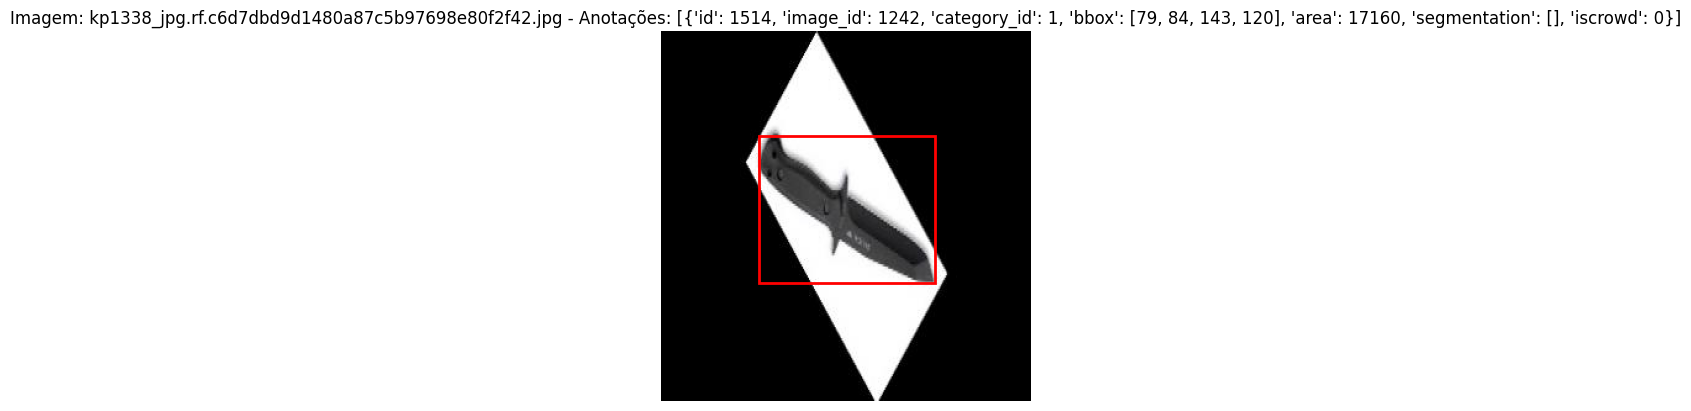

In [19]:
# Ajuste os caminhos conforme sua estrutura de diretórios
annotations_path = Path("anotacoes_limpo.json")  # Arquivo de anotações
images_dir = Path("train")                        # Pasta com as imagens reais

# Chama a função para exibir uma imagem aleatória com as anotações
show_random_image_with_annotation(annotations_path, images_dir)


Preparação do Modelo 
Split Dataset e Geração do Yaml

In [ ]:
def split_dataset(
    annotations_path: Path,
    output_dir: Path,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    seed: int = 42
) -> Tuple[Path, Path, Path]:

    random.seed(seed)
    with annotations_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    
    images = data.get("images", [])
    random.shuffle(images)
    total_images = len(images)
    
    train_count = int(total_images * train_ratio)
    val_count = int(total_images * val_ratio)
    test_count = total_images - train_count - val_count
    
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]
    
    train_ids = {img["id"] for img in train_images}
    val_ids = {img["id"] for img in val_images}
    test_ids = {img["id"] for img in test_images}
    
    def filter_annotations(annotations: List[Dict[str, Any]], valid_ids: set) -> List[Dict[str, Any]]:
        return [ann for ann in annotations if ann.get("image_id") in valid_ids]
    
    all_annotations = data.get("annotations", [])
    train_annotations = filter_annotations(all_annotations, train_ids)
    val_annotations = filter_annotations(all_annotations, val_ids)
    test_annotations = filter_annotations(all_annotations, test_ids)
    
    common_fields = {k: data[k] for k in ["info", "licenses", "categories"] if k in data}
    
    train_data = {**common_fields, "images": train_images, "annotations": train_annotations}
    val_data   = {**common_fields, "images": val_images, "annotations": val_annotations}
    test_data  = {**common_fields, "images": test_images, "annotations": test_annotations}
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    train_json = output_dir / "train.json"
    val_json = output_dir / "val.json"
    test_json = output_dir / "test.json"
    
    for path, dataset in zip([train_json, val_json, test_json], [train_data, val_data, test_data]):
        with path.open("w", encoding="utf-8") as f:
            json.dump(dataset, f, indent=4, ensure_ascii=False)
    
    logging.info(f"Divisão concluída! Total de imagens: {total_images}")
    logging.info(f" - Treino: {len(train_images)} imagens")
    logging.info(f" - Validação: {len(val_images)} imagens")
    logging.info(f" - Teste: {len(test_images)} imagens")
    logging.info(f"Arquivos salvos em: {output_dir}")
    
    return train_json, val_json, test_json

In [ ]:
def create_data_yaml(train_json_path: Path, train_images_dir: Path, val_images_dir: Path, output_yaml: Path) -> None:

    with train_json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    
    categories = data.get("categories", [])
    names = [cat["name"] for cat in categories]
    nc = len(names)
    
    content = (
        f"train: {str(train_images_dir)}\n"
        f"val: {str(val_images_dir)}\n"
        f"nc: {nc}\n"
        f"names: {names}\n"
    )
    
    with output_yaml.open("w", encoding="utf-8") as f:
        f.write(content)
    
    logging.info(f"Arquivo de configuração YAML criado: {output_yaml}")

In [22]:
# Caminho para o arquivo de anotações limpo
annotations_path = Path("anotacoes_limpo.json")  # Ajuste conforme necessário

# Diretório de saída para os arquivos divididos
output_dir = Path("dataset_split")

# Executa a divisão do dataset e recebe os caminhos dos arquivos gerados
train_json, val_json, test_json = split_dataset(annotations_path, output_dir)

# Defina os diretórios onde as imagens de treino e validação estão armazenadas.
# Esses caminhos devem ser compatíveis com o que será usado no treinamento (ex.: YOLOv5).
train_images_dir = Path("dataset/train/images")  # Exemplo: pasta com as imagens de treino
val_images_dir   = Path("dataset/val/images")      # Exemplo: pasta com as imagens de validação

# Cria o arquivo data.yaml usando as categorias do train.json
create_data_yaml(train_json, train_images_dir, val_images_dir, output_yaml=Path("data.yaml"))

# Após essa etapa, os arquivos train.json, val.json, test.json e o data.yaml estarão prontos para serem usados no treinamento.


INFO: Divisão concluída! Total de imagens: 2362
INFO:  - Treino: 1653 imagens
INFO:  - Validação: 354 imagens
INFO:  - Teste: 355 imagens
INFO: Arquivos salvos em: dataset_split
INFO: Arquivo de configuração YAML criado: data.yaml


In [ ]:
def prepare_dataset_dirs(
    src_dir: Path,
    dest_train_dir: Path,
    dest_val_dir: Path,
    dest_test_dir: Path,
    train_json: Path,
    val_json: Path,
    test_json: Path
) -> None:

    # Cria os diretórios de destino, se não existirem
    dest_train_dir.mkdir(parents=True, exist_ok=True)
    dest_val_dir.mkdir(parents=True, exist_ok=True)
    dest_test_dir.mkdir(parents=True, exist_ok=True)
    
    # Carrega os dados dos arquivos JSON
    with train_json.open("r", encoding="utf-8") as f:
        train_data = json.load(f)
    with val_json.open("r", encoding="utf-8") as f:
        val_data = json.load(f)
    with test_json.open("r", encoding="utf-8") as f:
        test_data = json.load(f)
    
    # Função auxiliar para copiar imagens de um dataset para o diretório destino
    def copy_images(dataset: dict, dest_dir: Path, label: str) -> None:
        for img in dataset.get("images", []):
            file_name = img["file_name"]
            src_path = src_dir / file_name
            dest_path = dest_dir / file_name
            if src_path.exists():
                shutil.copy(src_path, dest_path)
            else:
                logging.warning(f"Imagem de {label} não encontrada: {src_path}")
    
    # Copia as imagens para cada conjunto
    copy_images(train_data, dest_train_dir, "treino")
    copy_images(val_data, dest_val_dir, "validação")
    copy_images(test_data, dest_test_dir, "teste")
    
    logging.info("Diretórios preparados e imagens copiadas (se encontradas).")

In [24]:
# Ajuste os caminhos conforme sua estrutura
src_dir = Path(r"E:\hackton\train")  # Diretório original onde as imagens estão

dest_train_dir = Path(r"E:\hackton\yolov5\dataset\train\images")
dest_val_dir = Path(r"E:\hackton\yolov5\dataset\val\images")
dest_test_dir = Path(r"E:\hackton\yolov5\dataset\test\images")

train_json = Path(r"E:\hackton\dataset_split\train.json")
val_json = Path(r"E:\hackton\dataset_split\val.json")
test_json = Path(r"E:\hackton\dataset_split\test.json")

prepare_dataset_dirs(src_dir, dest_train_dir, dest_val_dir, dest_test_dir, train_json, val_json, test_json)
print("Diretórios preparados e imagens copiadas (se encontradas).")


INFO: Diretórios preparados e imagens copiadas (se encontradas).


Diretórios preparados e imagens copiadas (se encontradas).


Gera as labels para a pasta do Yolov5

In [ ]:
def convert_bbox_coco_to_yolo(bbox: List[float], img_width: int, img_height: int) -> Tuple[float, float, float, float]:
    x, y, w, h = bbox
    x_center = x + w / 2.0
    y_center = y + h / 2.0
    return (x_center / img_width, y_center / img_height, w / img_width, h / img_height)

In [ ]:
def generate_yolo_labels(json_path: Path, images_dir: Path, labels_dir: Path) -> None:

    labels_dir.mkdir(parents=True, exist_ok=True)
    
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    
    annotations_by_image: Dict[int, List[Dict[str, Any]]] = {}
    for ann in data.get("annotations", []):
        image_id = ann.get("image_id")
        annotations_by_image.setdefault(image_id, []).append(ann)
    
    for img in data.get("images", []):
        image_id = img.get("id")
        file_name = img.get("file_name")
        image_path = images_dir / file_name
        
        try:
            with Image.open(image_path) as im:
                img_width, img_height = im.size
        except Exception as e:
            logging.error(f"Erro ao abrir a imagem {image_path}: {e}")
            continue
        
        label_filename = Path(file_name).stem + ".txt"
        label_filepath = labels_dir / label_filename
        
        lines = []
        if image_id in annotations_by_image:
            for ann in annotations_by_image[image_id]:
                class_id = ann.get("category_id")
                bbox = ann.get("bbox")
                x_center, y_center, w_norm, h_norm = convert_bbox_coco_to_yolo(bbox, img_width, img_height)
                line = f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
                lines.append(line)
        
        with label_filepath.open("w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        logging.info(f"Labels gerados para: {file_name}")

In [27]:
# Geração dos labels para o conjunto de treino
print("Gerando labels para o conjunto de treino:")
train_json_path = Path("dataset_split/train.json")           # Arquivo JSON de treino
train_images_dir = Path("yolov5/dataset/train/images")         # Diretório com as imagens de treino
train_labels_dir = Path("yolov5/dataset/train/labels")         # Diretório para salvar os labels de treino
generate_yolo_labels(train_json_path, train_images_dir, train_labels_dir)

# Geração dos labels para o conjunto de validação
print("\nGerando labels para o conjunto de validação:")
val_json_path = Path("dataset_split/val.json")                # Arquivo JSON de validação
val_images_dir = Path("yolov5/dataset/val/images")             # Diretório com as imagens de validação
val_labels_dir = Path("yolov5/dataset/val/labels")             # Diretório para salvar os labels de validação
generate_yolo_labels(val_json_path, val_images_dir, val_labels_dir)


INFO: Labels gerados para: knife_1196_jpg.rf.fab3636a88a320f042cc1fa81ac6e9e9.jpg
INFO: Labels gerados para: KravMagaTraining4610_jpg.rf.6c3001473b9b7d999be94561295643c3.jpg
INFO: Labels gerados para: kp1195_jpg.rf.f728d7207f46dd87477bd0c7091fa971.jpg
INFO: Labels gerados para: kp1095_jpg.rf.5c973fe0d861db73383a3371cb73ab11.jpg
INFO: Labels gerados para: KravMagaTraining21110_jpg.rf.20ae9e2559a93e1a35e68703f045c981.jpg
INFO: Labels gerados para: k566_jpg.rf.4a113f2a7ef6a03529b572cbc900eaf4.jpg
INFO: Labels gerados para: k835_jpg.rf.3fbb02a6846f031aa4e571201b34ff71.jpg
INFO: Labels gerados para: kp1356_jpg.rf.51d2c5057b268141aa9bd7dda4602e2f.jpg
INFO: Labels gerados para: knife_1157_jpg.rf.d0084afe5fa27f3c0b20352762f2b432.jpg
INFO: Labels gerados para: KravMagaTraining20833_jpg.rf.b143d124778299b78550288f27089e03.jpg
INFO: Labels gerados para: kp1241_jpg.rf.a3e26d5837d697e4f78e2800bc58e811.jpg
INFO: Labels gerados para: k540_jpg.rf.33e505b9cb305d81b8825b58b0143dfb.jpg
INFO: Labels gerad

Gerando labels para o conjunto de treino:


INFO: Labels gerados para: KravMagaKnifeDefenseTechniques086_jpg.rf.249a30f0b95351eaf124c23c7fa5e0b2.jpg
INFO: Labels gerados para: k386_jpg.rf.0cf410be8a335f74bd402e334b38b355.jpg
INFO: Labels gerados para: knife_581_jpg.rf.c1e21940d18efc7f5dfe0baba6951018.jpg
INFO: Labels gerados para: k1185_jpg.rf.e5b664dc7385abee6cc090ea0c08dd42.jpg
INFO: Labels gerados para: k1079_jpg.rf.d1a69847fc6daf2f25a18852b473a033.jpg
INFO: Labels gerados para: k104_jpg.rf.92ed927ef7211494ad52022d00f1707d.jpg
INFO: Labels gerados para: k617_jpg.rf.102788b8a63585e82bc62b697318e50c.jpg
INFO: Labels gerados para: k506_jpg.rf.a2d1a1c910ded9b1805625cb339b7277.jpg
INFO: Labels gerados para: kp1077_jpg.rf.cc3d81d1c248ec0e0465e3d867bf212a.jpg
INFO: Labels gerados para: k559_jpg.rf.0ec6f9f31422a01c31ef0e37bb7e79cb.jpg
INFO: Labels gerados para: KravMagaKnifeDefenseTechniques474_jpg.rf.97711303c0460824cff8beae565fd79a.jpg
INFO: Labels gerados para: k553_jpg.rf.ac71670029fb71374ca6b5d35f104dc2.jpg
INFO: Labels gerados 


Gerando labels para o conjunto de validação:


INFO: Labels gerados para: k708_jpg.rf.b0a534d003f69b4eb5f3f1c617728dfb.jpg
INFO: Labels gerados para: kp1094_jpg.rf.17473103d1b9198106b45a4ceb76f87f.jpg
INFO: Labels gerados para: k57_jpg.rf.4855f585b2c7d51564ec5638044d471b.jpg
INFO: Labels gerados para: kp1156_jpg.rf.a9d617d7227f2454a678a96d4bb30e95.jpg
INFO: Labels gerados para: knifeDefenseTechnique108_jpg.rf.3bf15a84d44b0acd650f816164eefdd7.jpg
INFO: Labels gerados para: DefenseKnifeAttack0451_jpg.rf.13babe267657343914994399b8bea00d.jpg
INFO: Labels gerados para: knife_397_jpg.rf.72082565aafeeab1c27ba7dd31586056.jpg
INFO: Labels gerados para: kp1145_jpg.rf.eb386f505fc0bd795a6787fb2e69cb9f.jpg
INFO: Labels gerados para: KravMagaTraining20846_jpg.rf.2c90c94e7007f563bd14ca8a30ddb7fc.jpg
INFO: Labels gerados para: k1223_jpg.rf.316b2251d11d3e99812db4af177adf1e.jpg
INFO: Labels gerados para: MBsframe00199_jpg.rf.db13bb96e9edb14a63484fc800b0ec49.jpg
INFO: Labels gerados para: k138_jpg.rf.074af843bba28f256d844de95059c4f0.jpg
INFO: Labels 

Treino

In [ ]:
def train_yolov5(img_size: int, batch_size: int, epochs: int, weights: str, data_yaml: str) -> None:

    command = [
        "python", "yolov5/train.py",
        "--img", str(img_size),
        "--batch", str(batch_size),
        "--epochs", str(epochs),
        "--data", data_yaml,
        "--weights", weights
    ]
    logging.info("Executando treinamento com o comando:")
    logging.info(" ".join(command))
    
    # Executa o comando com Popen para capturar e imprimir a saída em tempo real, definindo encoding e errors
    process = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        encoding="utf-8",
        errors="replace"
    )
    
    # Leitura e impressão da saída em tempo real
    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output, end="")  # exibe cada linha conforme ela chega

    process.stdout.close()
    return_code = process.wait()
    
    if return_code != 0:
        logging.error("Erro no treinamento!")
    else:
        logging.info("Treinamento concluído com sucesso!")

In [ ]:
# Ajuste os hiperparâmetros conforme necessário
train_yolov5(img_size=640, batch_size=16, epochs=1, weights="yolov5s.pt", data_yaml="data.yaml")

INFO: Executando treinamento com o comando:
INFO: python yolov5/train.py --img 640 --batch 16 --epochs 1 --data data.yaml --weights yolov5s.pt


train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-411-gf4d8a84c Python-3.11.0rc2 torch-2.6.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj

Teste

In [ ]:
def test_model(weights: str, test_images_dir: Path, output_dir: Path) -> str:

    if not test_images_dir.exists():
        logging.error(f"Diretório de imagens de teste não encontrado: {test_images_dir}")
        return ""
    
    command = [
        "python", "yolov5/detect.py",
        "--weights", weights,
        "--source", str(test_images_dir),
        "--project", str(output_dir),
        "--save-txt",
        "--save-conf"
    ]
    
    logging.info("Executando teste com o comando:")
    logging.info(" ".join(command))
    
    result = subprocess.run(
        command, 
        capture_output=True, 
        text=True, 
        encoding="utf-8", 
        errors="replace"
    )
    
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    
    if result.returncode != 0:
        logging.error("Erro no teste:")
        logging.error(result.stderr)
        return ""
    else:
        # Combina stdout e stderr para garantir que toda a saída seja analisada
        combined_output = result.stdout + "\n" + result.stderr
        logging.info("Saída combinada do teste:")
        logging.info(combined_output)
        
        # Filtra as linhas que começam com "image" (assumindo que cada imagem gera uma linha)
        image_lines = [line for line in combined_output.splitlines() if line.strip().startswith("image")]
        
        total_images = len(image_lines)
        images_with_knife = 0
        total_knives = 0
        
        for line in image_lines:
            lower_line = line.lower()
            if "knife" in lower_line:
                images_with_knife += 1
                # Procura o número de "knife" usando regex, assumindo formato "N knife"
                match = re.search(r"(\d+)\s*knife", line, re.IGNORECASE)
                if match:
                    total_knives += int(match.group(1))
        
        images_without_knife = total_images - images_with_knife
        
        summary_text = (
            f"Das {total_images} imagens testadas, foram encontradas facas em {images_with_knife} imagens, "
            f"totalizando {total_knives} facas detectadas. Em {images_without_knife} imagens, nenhuma faca foi encontrada."
        )
        
        logging.info("Resumo do log de teste:")
        logging.info(summary_text)
        
        return summary_text


In [ ]:
# MUDAR  output_dir e weights para a pasta do ultimo treino feito

# Ajuste os caminhos conforme sua estrutura
test_images_dir = Path("yolov5/dataset/test/images")
output_dir = Path("yolov5/runs/detect/exp")

summary = test_model(
    weights="yolov5/runs/train/exp/weights/best.pt",
    test_images_dir=test_images_dir,
    output_dir=output_dir
)

print("Resumo do teste:")
print(summary)


STDOUT: 
STDERR: detect: weights=['yolov5/runs/train/exp2/weights/best.pt'], source=yolov5\dataset\test\images, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect\exp2, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-411-gf4d8a84c Python-3.11.0rc2 torch-2.6.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/355 E:\hackton\yolov5\dataset\test\images\--------_------_jpg.rf.5b5353191623109010164c7a35da4c4b.jpg: 640x640 (no detections), 151.6ms
image 2/355 E:\hackton\yolov5\dataset\test\images\--------_------_jpg.rf.a07a927ebc755279a6d430f47f786c3a.jpg: 640x640 1 knife, 136.6ms
image 3/35

In [ ]:
def send_alert_via_webhook(summary: str, recipient_email: str, webhook_url: str) -> None:

    payload = {
        "email": recipient_email,
        "summary": summary
    }
    
    try:
        response = requests.post(webhook_url, json=payload)
        if response.ok:
            logging.info("Alerta enviado com sucesso!")
        else:
            logging.error(f"Erro ao enviar alerta: {response.status_code} - {response.text}")
    except Exception as e:
        logging.error(f"Exceção ao enviar alerta: {e}")


In [ ]:
recipient_email = "joao.mamprin@gruposf.com.br"  # Substitua pelo e-mail de destino
webhook_url = "https://hook.us2.make.com/bmjkujkyahk1qfbapdbwy2mjic80fi6d"

send_alert_via_webhook(summary, recipient_email, webhook_url)
